In [10]:
from diffusers import StableDiffusionXLPipeline
import torch
import importlib
import sd_hooks
import utils
importlib.reload(sd_hooks)
importlib.reload(utils)
from sd_hooks import SDHiddenRecorder
from typing import Literal
from modules import namespace
from typing import Literal

In [29]:
pipeline: StableDiffusionXLPipeline = StableDiffusionXLPipeline.from_single_file(
    "/root/ComfyUI/models/checkpoints/animagine-xl-3.1.safetensors", 
    torch_dtype=torch.float16, 
    variant="fp16", 
    safety_checker=None, 
    config='/root/ComfyUI/models/checkpoints/Animagine3.1',
).to("cuda")
pipeline.load_lora_weights("/root/ComfyUI/models/loras/firefly_V3.safetensors")
torch.manual_seed(42)
scales = {
    "text_encoder": 0.5,
    "text_encoder_2": 0.5,  # only usable if pipe has a 2nd text encoder
    "unet": {
        "down": 0.9,  # all transformers in the down-part will use scale 0.9
        # "mid"  # in this example "mid" is not given, therefore all transformers in the mid part will use the default scale 1.0
        "up": {
            "block_0": 0.6,  # all 3 transformers in the 0th block in the up-part will use scale 0.6
            "block_1": [0.4, 0.8, 1.0],  # the 3 transformers in the 1st block in the up-part will use scales 0.4, 0.8 and 1.0 respectively
        }
    }
}
pipeline.set_adapters("my_adapter", scales)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
hidden_ids = [
    'up_blocks.0.resnets.0',
    'up_blocks.0.resnets.1',
    'up_blocks.0.resnets.2',
    'up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q',
    'mid_block'
]
def record_a_generating_process(pipeline, hidden_ids, prompt, n_prompt, seed):
    generator = torch.Generator("cuda").manual_seed(seed)
    recorder = SDHiddenRecorder(pipeline, hidden_ids)
    with torch.no_grad():
        image = pipeline(
            prompt=prompt, 
            negative_prompt=n_prompt,
            num_inference_steps=20,
            callback_on_step_end=recorder,
            generator=generator
        ).images[0]
    recorder.hiddens.pop()
    return recorder, image

In [32]:
prompt = "firefly_\\(honkai:_star_rail\\), 1 girl, looking at viewer, upper body, simple background"
negative_prompt = "bad anatomy,blurry,(worst quality:1.8),low quality,hands bad,face bad,(normal quality:1.3),bad hands,mutated hands and fingers,extra legs,extra arms,duplicate,cropped,text,jpeg,artifacts,signature,watermark,username,blurry,artist name,trademark,title,multiple view,Reference sheet,long body,multiple breasts,mutated,bad anatomy,disfigured,bad proportions,duplicate,bad feet,artist name,ugly,text font ui,missing limb,monochrome,"

In [33]:
recorder1, image1 = record_a_generating_process(pipeline, hidden_ids, prompt, negative_prompt, 42)
recorder2, image2 = record_a_generating_process(pipeline, hidden_ids, prompt, negative_prompt, 43)

Hooking down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q, Hooking up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q, Hooking up_blocks.0.resnets.0, Hooking up_blocks.0.resnets.1, Hooking up_blocks.0.resnets.2, Hooking mid_block, 

  0%|          | 0/20 [00:00<?, ?it/s]

Hooking down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q, Hooking up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q, Hooking up_blocks.0.resnets.0, Hooking up_blocks.0.resnets.1, Hooking up_blocks.0.resnets.2, Hooking mid_block, 

  0%|          | 0/20 [00:00<?, ?it/s]

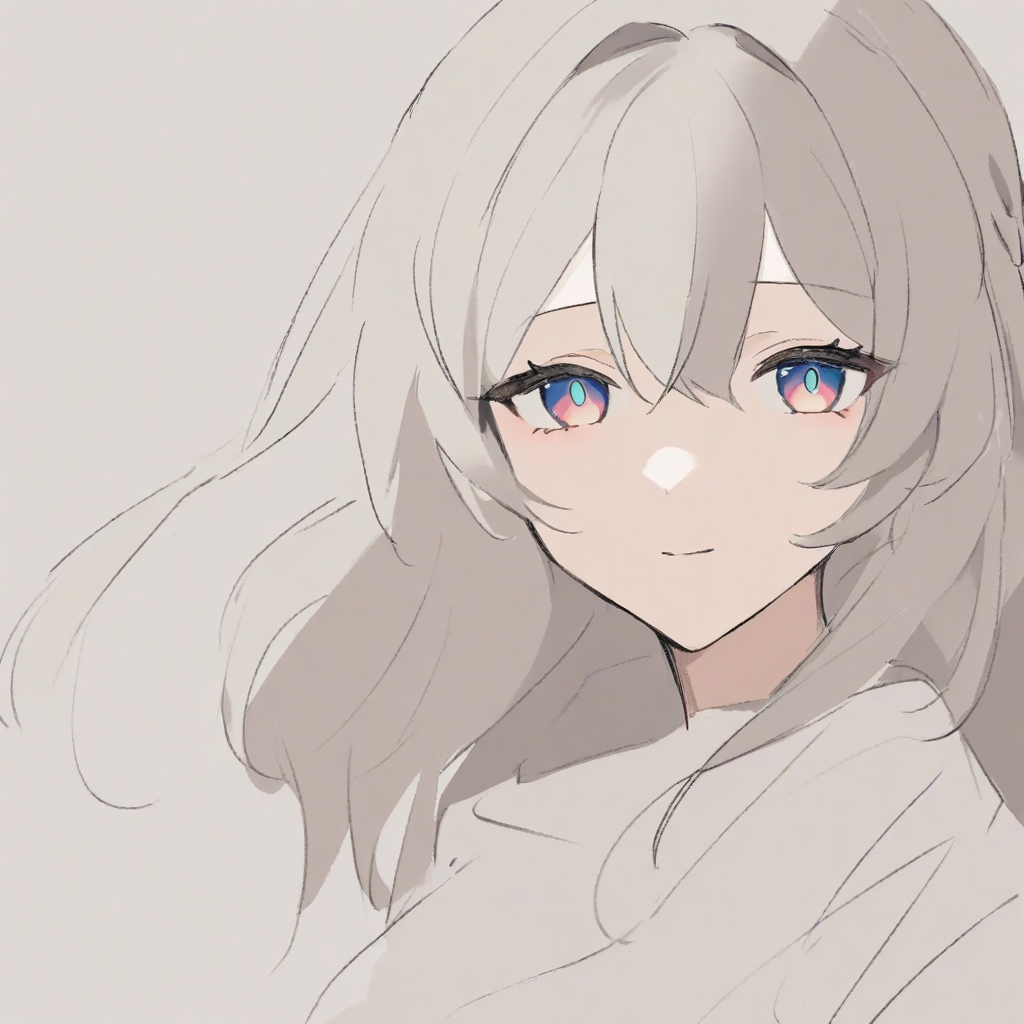

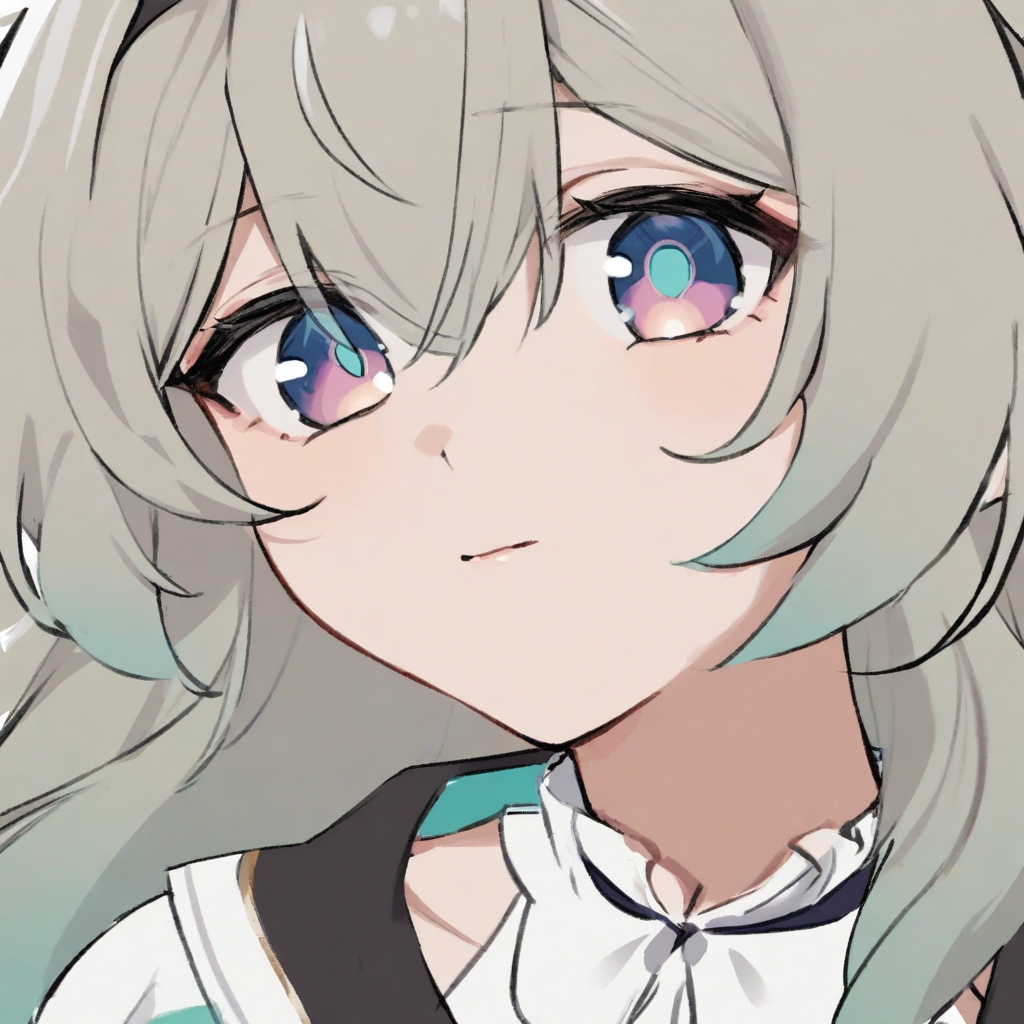

In [34]:
display(image1)
display(image2)